# The Wilson score interval and weighted histograms

The Wilson Score interval (WSI) has won the LHCb internal challenge for the most suitable interval for efficiencies. The question is what to do when events are weighted was left open at the time. It is addressed here, the WSI can be used also with weighted histograms if ordinary counts in unweighted histograms are replaced with effective counts in weighted histograms.

In [8]:
import numpy as np
import boost_histogram as bh
from matplotlib import pyplot as plt

The Wilson score interval is given by, see e.g. https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval:
$$
p_\text{min} = \frac{n_S + \frac 12 z^2}{n_S + n_F + z^2} - \frac{z}{n_S + n_F + z^2} \sqrt{\frac{n_S n_F}{n_S + n_F} + \frac{z^2}{4}}
$$
$$
p_\text{max} = \frac{n_S + \frac 12 z^2}{n_S + n_F + z^2} + \frac{z}{n_S + n_F + z^2} \sqrt{\frac{n_S n_F}{n_S + n_F} + \frac{z^2}{4}}
$$
with $n_S$ counts of selected events, $n_F$ counts of rejected events, $z$ number of sigmas ($z = 1$ for standard intervals).

In case of weighted events, the $n_S,n_F$ are the effective counts, computed as
$$
n_\text{effective} = \frac{\big(\sum_i w_i\big)^2}{\sum_i w^2_i}.
$$

In [9]:
def wilson_score_interval(n_s, n_f, z=1):
    n = n_s + n_f
    z2 = z * z
    center = (n_s + 0.5 * z2) / (n + z2)
    delta = z / (n + z2) * np.sqrt(n_s * n_f / n + 0.25 * z2)
    return center - delta, center + delta

In boost-histogram, this is computed as `n_eff = h.values() ** 2 / h.variances()` for a histogram `h` with `WeightedSum` storage. Since we look into a single bin here, we skip the histogram and just use the `WeightedSum()` accumulator directly, which is one element of the storage.

In [14]:
p_truth = 0.1

rng = np.random.default_rng(1)

w_s = bh.accumulators.WeightedSum()
w_f = bh.accumulators.WeightedSum()

w = rng.exponential(10, size=100)
m = rng.uniform(size=len(w)) < p_truth

w_s.fill(w[m]), w_f.fill(w[~m])

(WeightedSum(value=29.7824, variance=357.384),
 WeightedSum(value=1008.21, variance=25830.4))

In [15]:
n_s = w_s.value ** 2 / w_s.variance if w_s.variance > 0 else 0
n_f = w_f.value ** 2 / w_f.variance if w_f.variance > 0 else 0

p = n_s / (n_s + n_f)
p_min, p_max = wilson_score_interval(n_s, n_f)

print(f"efficiency = {p:.2f} - {p-p_min:.2f} + {p_max-p:.2f}")

efficiency = 0.06 - 0.03 + 0.05


Note that the error is asymmetric in general. This is especially noticable when p is close to 0 or 1.

Let's check with a parametric bootstrap simulation whether this uncertainty is correct. It is parametric because we know that the weights are exponentially distributed.

efficiency = 0.06 - 0.03 + 0.05
efficiency(boot) = 0.06 - 0.03 + 0.03


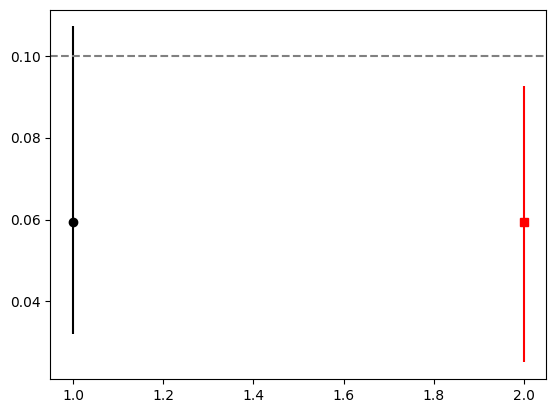

In [16]:
rng = np.random.default_rng(1)

w_mean = np.mean(w)

p_boot = []
for iboot in range(1000):
    wi = rng.exponential(w_mean, size=len(w))
    mi = rng.uniform(size=len(w)) < p
    t_s = bh.accumulators.WeightedSum()
    t_f = bh.accumulators.WeightedSum()
    t_s.fill(wi[mi])
    t_f.fill(wi[~mi])
    p_boot.append(t_s.value / (t_s.value + t_f.value))
    
center = np.mean(p_boot)
delta = np.std(p_boot)
p_min_boot = center - delta
p_max_boot = center + delta

plt.errorbar([1], [p], [[p-p_min], [p_max-p]], fmt="ok")
plt.errorbar([2], [p], [[p-p_min_boot], [p_max_boot-p]], fmt="sr")
plt.axhline(p_truth, ls="--", color="0.5")

print(f"efficiency = {p:.2f} - {p-p_min:.2f} + {p_max-p:.2f}")
print(f"efficiency(boot) = {p:.2f} - {p-p_min_boot:.2f} + {p_max_boot-p:.2f}")

Ok, check passed.